# 大黒海釣り施設、入場者数分析その１

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [6, 4]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [2]:
# 大黒、アジに絞ってSQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'daikoku'
    and r.Date > '2018-01-01'
'''
df=pd.read_sql_query(sql, conn)
df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2018-02-18,アジ,3,22.0,23.0,10.0,119.0
1,2018-02-20,アジ,4,23.0,25.0,10.0,56.0
2,2018-02-21,アジ,2,19.0,21.0,10.3,44.0
3,2018-02-23,アジ,3,22.0,24.0,10.5,31.0
4,2018-02-26,アジ,4,22.0,23.0,10.5,36.0


In [3]:
# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセット

df = df.set_index('Date')

## 平日、休日の入場者数比較

<AxesSubplot:xlabel='BizDay', ylabel='Quantity'>

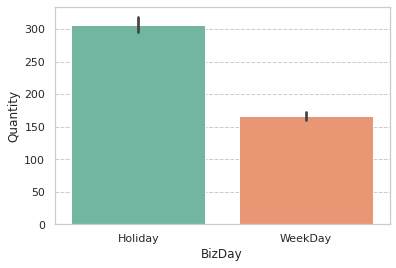

In [4]:
# 入場者数の比較

sns.barplot(x='BizDay', y='Quantity', data=df, palette='Set2')

In [5]:
# 平日と休日の比較

df.groupby('BizDay').mean()

,Count,SizeMin,SizeMax,WaterTemp,Quantity
BizDay,,,,,
Holiday,219.284375,14.340625,25.706250,18.639871,306.785489
WeekDay,221.361409,14.595712,26.777948,18.707621,165.761538


In [6]:
# seaborn でプロットしやすいようにデータフレームを横縦変換する

df2 = df[['Count', 'SizeMin', 'SizeMax','WaterTemp', 'Quantity']]
df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})

# 平日、休日判定列を追加

df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットして、各年月日列を追加

df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.strftime('%U').astype(int) # df3.index.week
df3.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2018-02-18,Count,3.0,Holiday,2018,2,49,7
2018-02-18,SizeMin,22.0,Holiday,2018,2,49,7
2018-02-18,SizeMax,23.0,Holiday,2018,2,49,7
2018-02-18,WaterTemp,10.0,Holiday,2018,2,49,7
2018-02-18,Quantity,119.0,Holiday,2018,2,49,7


<AxesSubplot:xlabel='Month', ylabel='Value'>

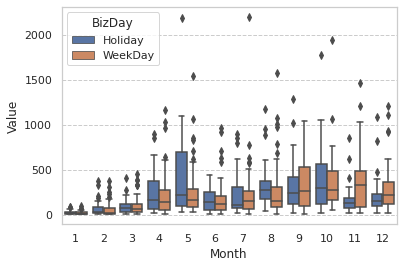

In [7]:
# 月別の入場者数の分析

df6 = df3.loc[df3['Metric'].isin(['Count'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="BizDay")

## 年度別入場者数の比較

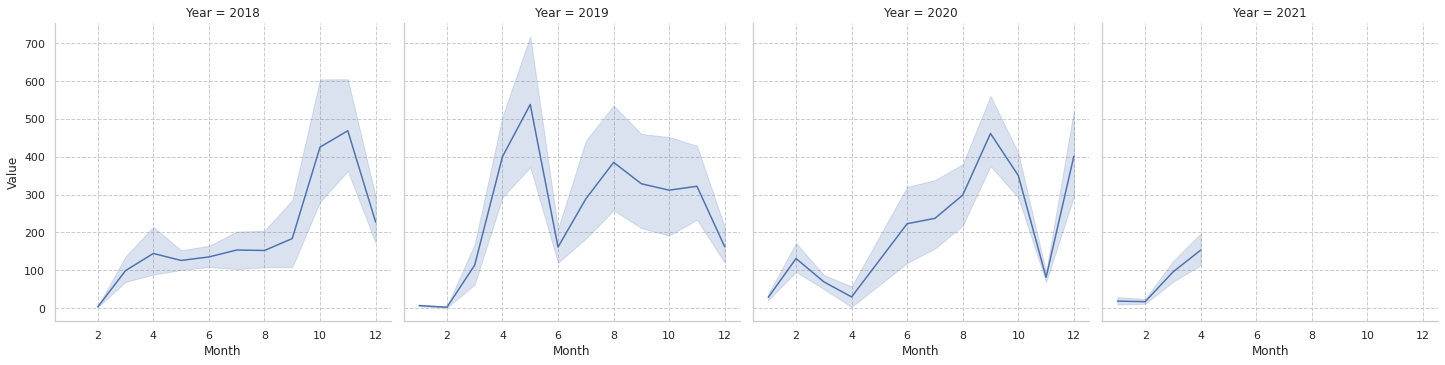

In [9]:
# 年度別入場者数、各年度グラフ

sns.relplot(data=df6, x='Month', y='Value', col='Year', kind="line")